# WEATHER data from Warsaw station

In [538]:
import pandas as pd
from matplotlib import pyplot
import seaborn as sn
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime as dt

from tensorflow import keras


# Read the CSV file
all_data = pd.read_csv("data_lodz.csv")

In [539]:
import warnings
warnings.filterwarnings("ignore") #:D

### Note - columns:

valid:
timestamp of the observation - every half hour

tmpf:
Air Temperature in Fahrenheit

relh:
Relative Humidity in %

drct:
Wind Direction in degrees from *true* north

sknt:
Wind Speed in knots

p01i:
One hour precipitation for the period from the observation time to the time of the previous hourly precipitation reset. This varies slightly by site. Values are in inches. This value may or may not contain frozen precipitation melted by some device on the sensor or estimated by some other means. Unfortunately, we do not know of an authoritative database denoting which station has which sensor.



In [540]:
df_with_direct = all_data[["valid", "tmpf", "relh", "drct", "sknt","p01i"]]

df_with_direct=df_with_direct.replace('M', pd.np.nan)

nan_count = df_with_direct.isna().sum()

print(nan_count)

valid        0
tmpf         0
relh        84
drct     16504
sknt         1
p01i         0
dtype: int64


In [541]:
# drct deletion
df = df_with_direct.copy()
df.drop('drct',axis='columns', inplace=True)

# 'tmpf' NaN into data from previous timestamp
bool_df = df['tmpf'].isnull()
indexes = df[bool_df].index
for i in indexes:
    df['tmpf'][i]=df['tmpf'][i-1]

# 'tmpf' NaN into data from previous timestamp
bool_df = df['relh'].isnull()
indexes = df[bool_df].index
for i in indexes:
    df['relh'][i]=df['relh'][i-1]

# 'tmpf' NaN into data from previous timestamp
bool_df = df['sknt'].isnull()
indexes = df[bool_df].index
for i in indexes:
    df['sknt'][i]=df['sknt'][i-1]

nan_count = df.isna().sum()

print(nan_count)

valid    0
tmpf     0
relh     0
sknt     0
p01i     0
dtype: int64


In [542]:
#Fahrenheit => Celsius

df['tmpf'] = df['tmpf'].astype(float)
df['relh'] = df['relh'].astype(float)
df['sknt'] = df['sknt'].astype(float)
df = df.assign(temp = lambda x: (5/9)*(x['tmpf']-32))
df.drop('tmpf',axis='columns', inplace=True)

# date
df['valid']=pd.to_datetime(df['valid'])
df['day'] = df['valid'].dt.day
df['month'] = df['valid'].dt.month
df['year'] = df['valid'].dt.year
df['time'] = df['valid'].dt.time

dates = df['valid']

df.drop('valid',axis='columns', inplace=True)


df.head()

,relh,sknt,p01i,temp,day,month,year,time
0,92.97,10.0,0.0,0.0,1,1,2015,01:00:00
1,92.97,8.0,0.0,0.0,1,1,2015,01:30:00
2,100.00,7.0,0.0,0.0,1,1,2015,02:00:00
3,100.00,7.0,0.0,0.0,1,1,2015,02:30:00
4,100.00,7.0,0.0,0.0,1,1,2015,03:00:00


Only for temperature:

In [543]:
temp = df['temp'].values

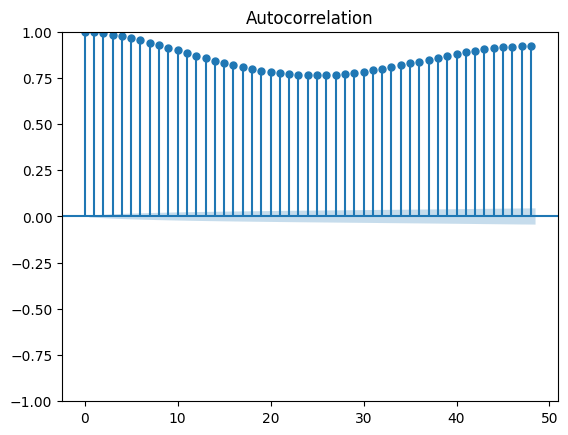

In [544]:
plot_acf(temp, lags = 48)
pyplot.show()

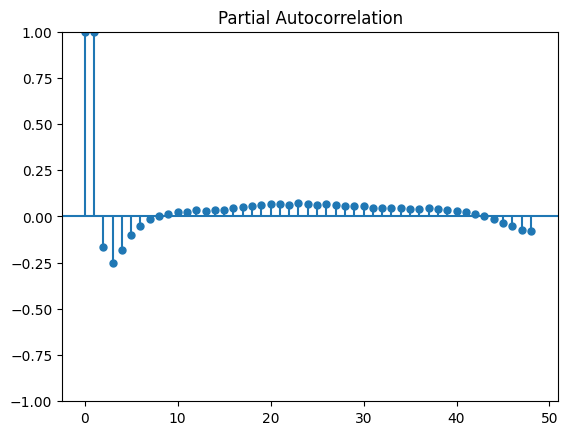

In [545]:
plot_pacf(temp, lags=48)
pyplot.show()

### Correlations in data

          temp      relh      sknt
temp  1.000000 -0.519389  0.002464
relh -0.519389  1.000000 -0.225321
sknt  0.002464 -0.225321  1.000000


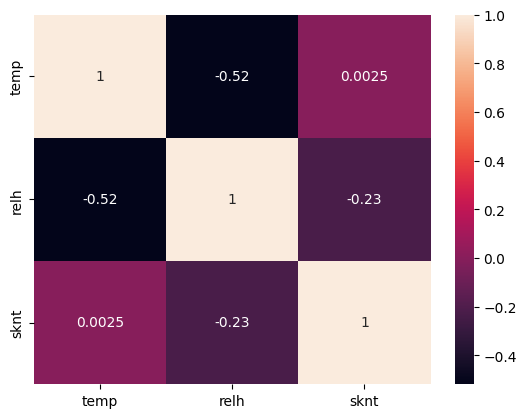

In [546]:
df_no_date= df[["temp","relh", "sknt"]]
df_no_date=df_no_date.apply(lambda x: pd.to_numeric(x, errors='ignore'))
df_no_date.head()
corr_matrix  = df_no_date.corr()
print(corr_matrix)
sn.heatmap(corr_matrix, annot=True)
plt.show()

### Plot for precipitaion - 0? (Warsaw and Lodz) - another station maybe...?

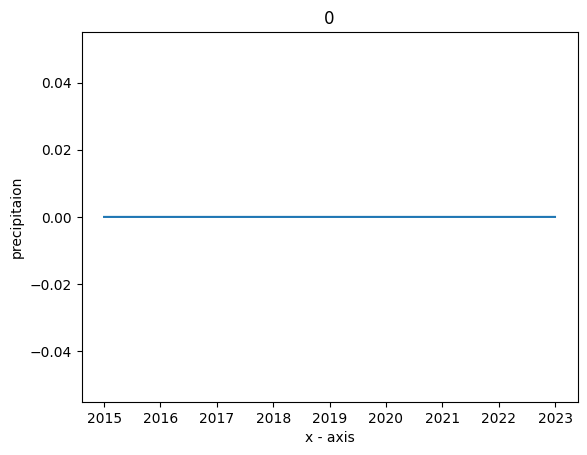

In [547]:
# data plot precipitation - 0??????
# plotting the points  
plt.plot(dates, 
df['p01i']) 
  
# naming the x axis 
plt.xlabel('x - axis') 
# naming the y axis 
plt.ylabel('precipitaion') 
  
# giving a title to my graph 
plt.title('0') 
  
# function to show the plot 
plt.show() 

### Plot for temperature 2021

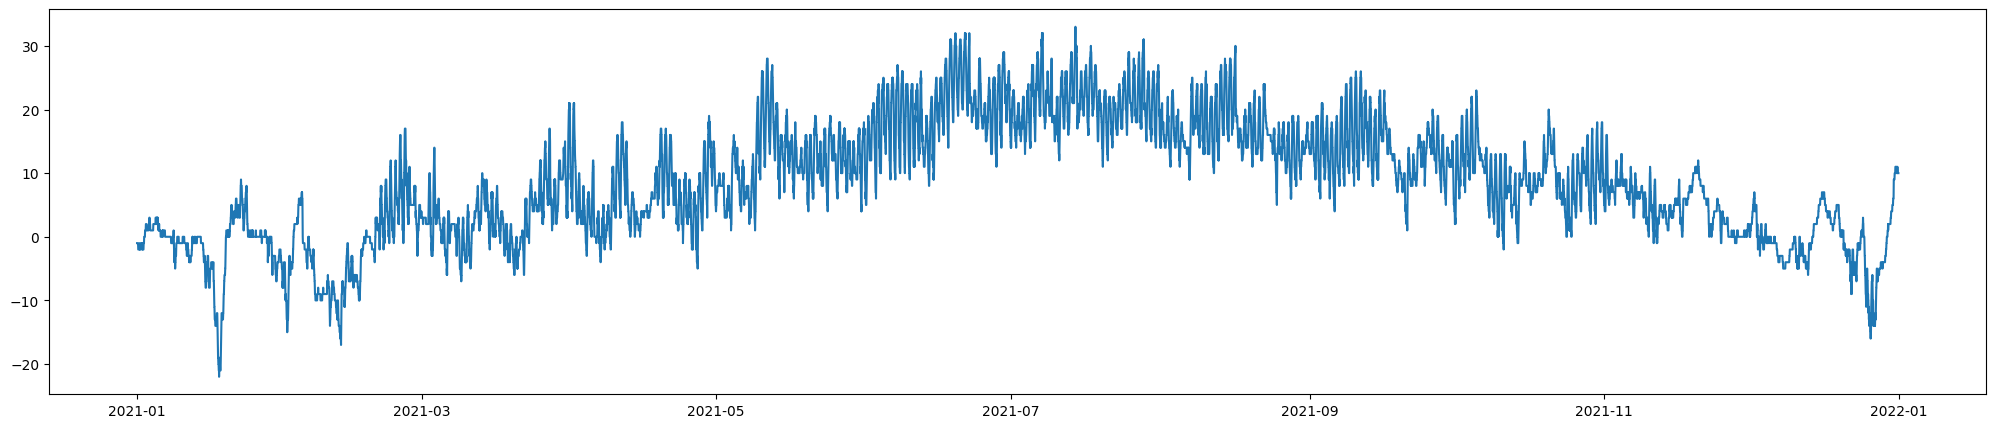

In [548]:
df_2021 = df[df['year'] == 2021]
dates_2021 = dates[df['year'] == 2021]

temp = df_2021['temp'].values

f = plt.figure() 
f.set_figwidth(25) 
f.set_figheight(5) 
plt.plot(dates_2021, temp) 


### from 2015 to 2021 weather : 2022 for validation

In [549]:
# for learning
df_2015_2021 = df[(df['year'] <= 2021)]
# dates_2015_2021 = dates[df['year'] <= 2021]

# for validation
df_2022 = df[(df['year'] == 2022)]
# dates_2022 = dates[df['year'] == 2022]

# LSTM network model
- month feature in the network if possible or model for each season / 2 seasons - then data batches as input

In [550]:
# train data
train_data = df_2015_2021[["temp", "relh", "sknt"]]
date_train = df_2015_2021[["month"]]

#valid data
valid_data = df_2022[["temp", "relh", "sknt"]]
date_valid = df_2022[["month"]].reset_index(drop=True)

In [552]:
def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std

In [553]:
tnormalizedf_data =  normalize(train_data)
n_train_data = tnormalizedf_data.reset_index(drop=True)

vnormalizedf_data =  normalize(valid_data)
n_val_data = vnormalizedf_data.reset_index(drop=True)

# training_size = int ( 0.8 * tnormalizedf_data.shape[0])  
# train_data = tnormalizedf_data.loc[0 : training_size - 1]
# val_data = tnormalizedf_data.loc[training_size:]

In [555]:
# 12h -> 24 timesteps - weather in +1h -> when = 2 timesteps
steps = 24
when = 2
sequence_length = steps/2

start = steps + when
# end = when + training_size

# only for july
x_train = n_train_data[date_train['month'] == 7].values
# y_train_prim = normalizedf_data.iloc[start:end]
# y_train = y_train_prim[dat['month' == 7]]

te = date_train['month'] == 7
te  = te.index[te] + start
y_train = n_train_data.iloc[te].values

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    data=x_train,
    targets=y_train,
    sequence_length=sequence_length,
    sampling_rate=2,
    batch_size=64,
)

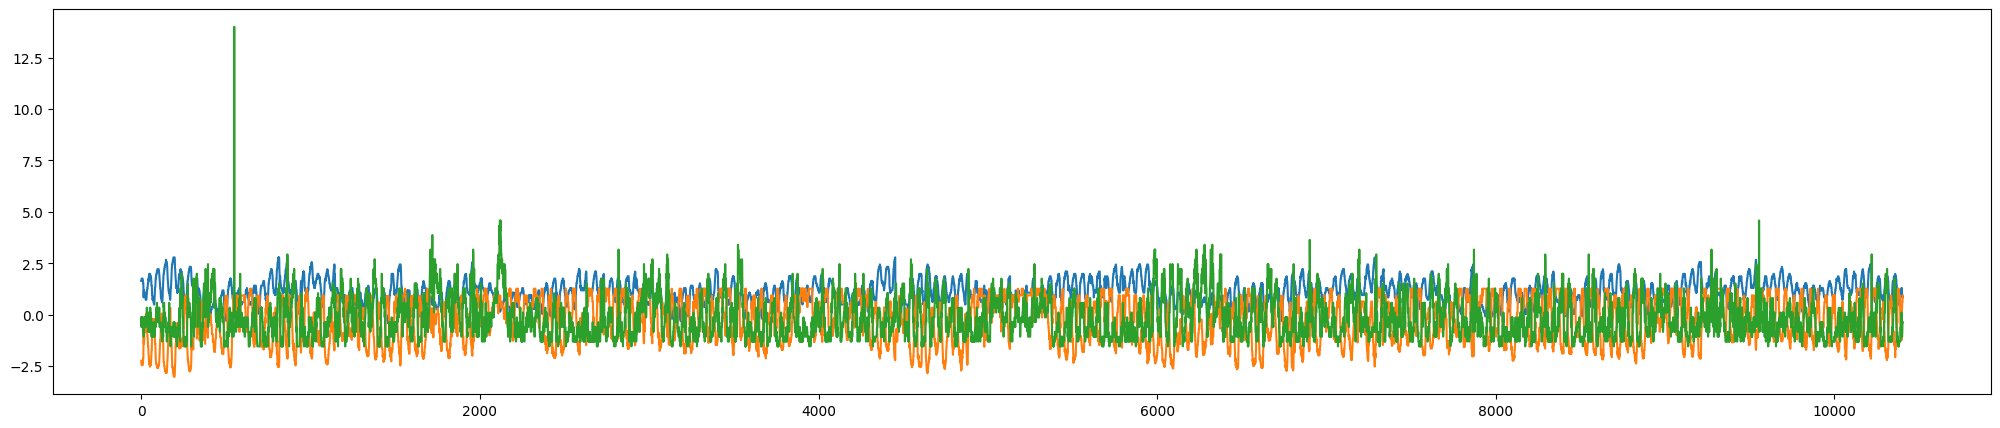

In [564]:
f = plt.figure() 
f.set_figwidth(25) 
f.set_figheight(5) 
plt.plot(y_train) 

In [557]:
x_val = n_val_data[date_valid['month'] == 7].values
# y_train_prim = normalizedf_data.iloc[start:end]
# y_train = y_train_prim[dat['month' == 7]]

te = date_valid['month'] == 7
te  = te.index[te] + start
y_val = n_val_data.iloc[te]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=2,
    batch_size=64,
)

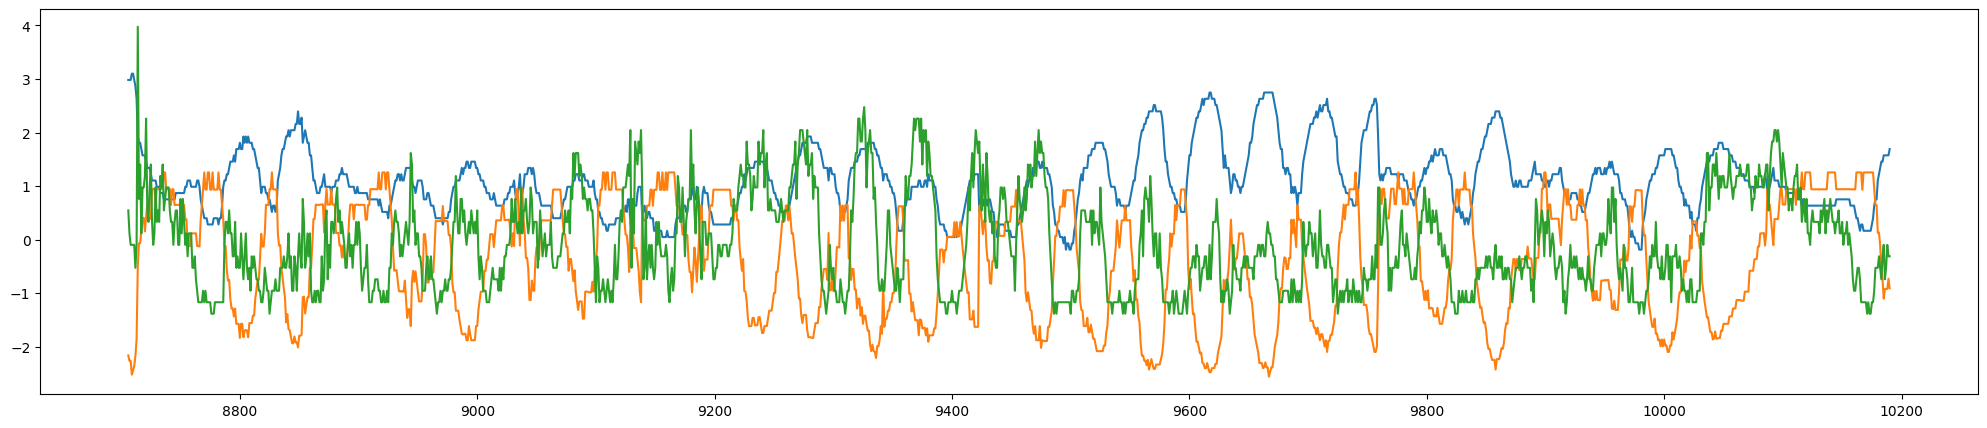

In [558]:
f = plt.figure() 
f.set_figwidth(25) 
f.set_figheight(5) 
plt.plot(y_val) 

In [565]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    
# the simplest model from keras
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(name="Weather_forcaster",inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "Weather_forcaster"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 12, 3)]           0         
                                                                 
 lstm_16 (LSTM)              (None, 32)                4608      
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4641 (18.13 KB)
Trainable params: 4641 (18.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(
    dataset_train,
    epochs=10,
    validation_data=dataset_val
)

loss = history.history["loss"]
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, "b", label="Training loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# more complex LSTM model